In [12]:
import pandas as pd
import os

def build_usage_df(messages_path, catalysts_path=None):
    df = pd.read_excel(messages_path)

    # catalysts_path가 있으면 df2 불러와서 병합
    if catalysts_path and os.path.exists(catalysts_path):
        df2 = pd.read_excel(catalysts_path)

        # df2를 df 구조에 맞게 맞춰서 결합
        df_columns = df.columns
        df2_like_df = pd.DataFrame(columns=df_columns)
        df2_like_df['User Email'] = df2['User Email']
        df2_like_df['Created At'] = df2['Created At']

        df = pd.concat([df, df2_like_df], ignore_index=True)

    # 이메일 → 유저 이름 매핑
    email_to_name = df.loc[df['User Name'].notna(), ['User Email', 'User Name']] \
                      .drop_duplicates() \
                      .set_index('User Email')['User Name'].to_dict()

    df['User Name'] = df.apply(
        lambda row: email_to_name.get(row['User Email'], row['User Name']),
        axis=1
    )

    df['Function Mode'] = df.get('Function Mode', 'catalysts').fillna('catalysts')
    df['Sender'] = df.get('Sender', 'user').fillna('user')

    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df = df[df['sender'] == 'user']
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['status'] = 'active'

    return df

companies = ['carret', 'cgsi', 'macquarie', 'clsa', 'anek', 'masterton', 'dendur', 'veda', 'rocksprings', 'icici', 'turiya']

for company in companies:
    try:
        messages_file = f"{company}_messages.xlsx"
        catalysts_file = f"{company}_catalysts.xlsx"
        
        df = build_usage_df(messages_file, catalysts_file)
        globals()[f'df_{company}'] = df
    except Exception as e:
        print(f"[{company}] 처리 중 오류 발생: {e}")


/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/3648594800.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df2_like_df], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/3648594800.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df2_like_df], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/3648594800.py:17: FutureWarning: The behavior of DataFrame concatenatio

In [13]:
import pandas as pd

# 불러올 기업 리스트
companies = ['carret', 'cgsi', 'macquarie', 'clsa', 'anek', 'masterton', 'dendur', 'veda', 'rocksprings', 'icici', 'turiya']

# users.xlsx 파일에서 기업별 joined 유저 시트 읽기
for company in companies:
    try:
        df_joined = pd.read_excel('users.xlsx', sheet_name=company)
        globals()[f'df_{company}_joined'] = df_joined
    except Exception as e:
        print(f"[{company}] joined 유저 시트 불러오기 실패: {e}")


In [14]:
for company in companies:
    try:
        df_usage = globals().get(f'df_{company}')
        df_joined = globals().get(f'df_{company}_joined')

        if df_usage is None or df_joined is None:
            print(f"[{company}] usage 또는 joined 데이터 누락. 건너뜀.")
            continue

        used_emails = set(df_usage['user_email'].unique())
        joined_emails = set(df_joined['user_email'].unique())

        # usage에 없는 joined 유저만 추출
        joined_no_usage = df_joined[~df_joined['user_email'].isin(used_emails)].copy()

        # usage 구조에 맞춰 널값 채우기
        df_missing = pd.DataFrame(columns=df_usage.columns)

        for col in ['user_email', 'user_name', 'organization']:
            if col in df_missing.columns and col in joined_no_usage.columns:
                df_missing[col] = joined_no_usage[col].values

        df_missing['status'] = 'joined_no_usage'

        # 병합
        df_merged = pd.concat([df_usage, df_missing], ignore_index=True)

        # 최종 저장
        globals()[f'df_{company}'] = df_merged

    except Exception as e:
        print(f"[{company}] joined 병합 실패: {e}")


/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/2826649978.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged = pd.concat([df_usage, df_missing], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/2826649978.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged = pd.concat([df_usage, df_missing], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/2826649978.py:26: FutureWarning: The behavior o

In [15]:
import pandas as pd

invited_suffix = "_invited"
invited_sheet_names = pd.ExcelFile('users.xlsx').sheet_names  # 시트 목록 미리 확인

for company in companies:
    sheet_name = company + invited_suffix
    if sheet_name in invited_sheet_names:
        try:
            df_invited = pd.read_excel('users.xlsx', sheet_name=sheet_name)
            globals()[f'df_{company}_invited'] = df_invited
        except Exception as e:
            print(f"[{company}] invited 시트 로딩 실패: {e}")
    else:
        print(f"[{company}] invited 시트 없음: 건너뜀")


[macquarie] invited 시트 없음: 건너뜀
[dendur] invited 시트 없음: 건너뜀
[veda] invited 시트 없음: 건너뜀
[icici] invited 시트 없음: 건너뜀
[turiya] invited 시트 없음: 건너뜀


In [16]:
for company in companies:
    try:
        df_usage = globals().get(f'df_{company}')
        df_invited = globals().get(f'df_{company}_invited')

        if df_usage is None or df_invited is None:
            print(f"[{company}] usage 또는 invited 데이터 누락. 건너뜀.")
            continue

        # usage 구조에 맞춰 invited 데이터 널값 채우기
        df_missing = pd.DataFrame(columns=df_usage.columns)

        for col in ['user_email', 'organization', 'status']:
            if col in df_missing.columns and col in df_invited.columns:
                df_missing[col] = df_invited[col].values

        # 병합
        df_merged = pd.concat([df_usage, df_missing], ignore_index=True)

        # 최종 저장
        globals()[f'df_{company}'] = df_merged

    except Exception as e:
        print(f"[{company}] invited 병합 실패: {e}")


[macquarie] usage 또는 invited 데이터 누락. 건너뜀.
[dendur] usage 또는 invited 데이터 누락. 건너뜀.
[veda] usage 또는 invited 데이터 누락. 건너뜀.
[icici] usage 또는 invited 데이터 누락. 건너뜀.
[turiya] usage 또는 invited 데이터 누락. 건너뜀.


/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/1945249511.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged = pd.concat([df_usage, df_missing], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/1945249511.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_merged = pd.concat([df_usage, df_missing], ignore_index=True)
/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/1945249511.py:18: FutureWarning: The behavior o

In [17]:
import pandas as pd

# 기업 리스트
companies = ['carret', 'cgsi', 'macquarie', 'clsa', 'anek', 'masterton', 'dendur', 'veda', 'rocksprings', 'icici', 'turiya']

# 사용 가능한 DataFrame만 수집
dfs_to_merge = []

for company in companies:
    df = globals().get(f'df_{company}')
    if df is not None:
        dfs_to_merge.append(df)
    else:
        print(f"[{company}] 데이터 누락 → 병합 대상에서 제외")

# 병합
df_all = pd.concat(dfs_to_merge, ignore_index=True, sort=False)  # 컬럼 정렬 없이 널값으로 자동 보정

df_all.to_csv('df_all.csv', index=False)

/var/folders/l1/ktg7ylkj42q3hp4jh40_3_xc0000gq/T/ipykernel_71815/1237485377.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(dfs_to_merge, ignore_index=True, sort=False)  # 컬럼 정렬 없이 널값으로 자동 보정


/Users/gyuhyun/Documents/Users/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


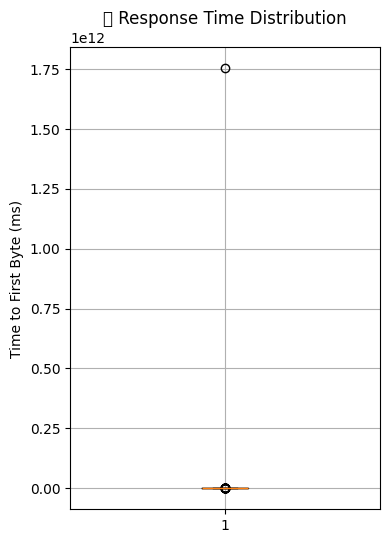

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
# df = pd.read_csv("your_data.csv")  # 또는 이미 df가 있을 경우 생략

# 박스플롯
plt.figure(figsize=(4, 6))
plt.boxplot(df_macquarie['time_to_first_byte'].dropna(), vert=True)
plt.ylabel("Time to First Byte (ms)")
plt.title("📦 Response Time Distribution")
plt.grid(True)
plt.show()


In [8]:
import numpy as np


df_all['time_to_first_byte'] = df_all['time_to_first_byte'].apply(
    lambda x: x if pd.isna(x) or x <= 300_000 else np.nan
)


# NaN 제외한 값으로 통계 요약
df_ttfb = df_all[df_all['time_to_first_byte'].notna()]
print(df_ttfb['time_to_first_byte'].describe())


count      1089.000000
mean      42040.419651
std       39284.567363
min     -217213.000000
25%       21678.000000
50%       28532.000000
75%       45403.000000
max      285718.000000
Name: time_to_first_byte, dtype: float64


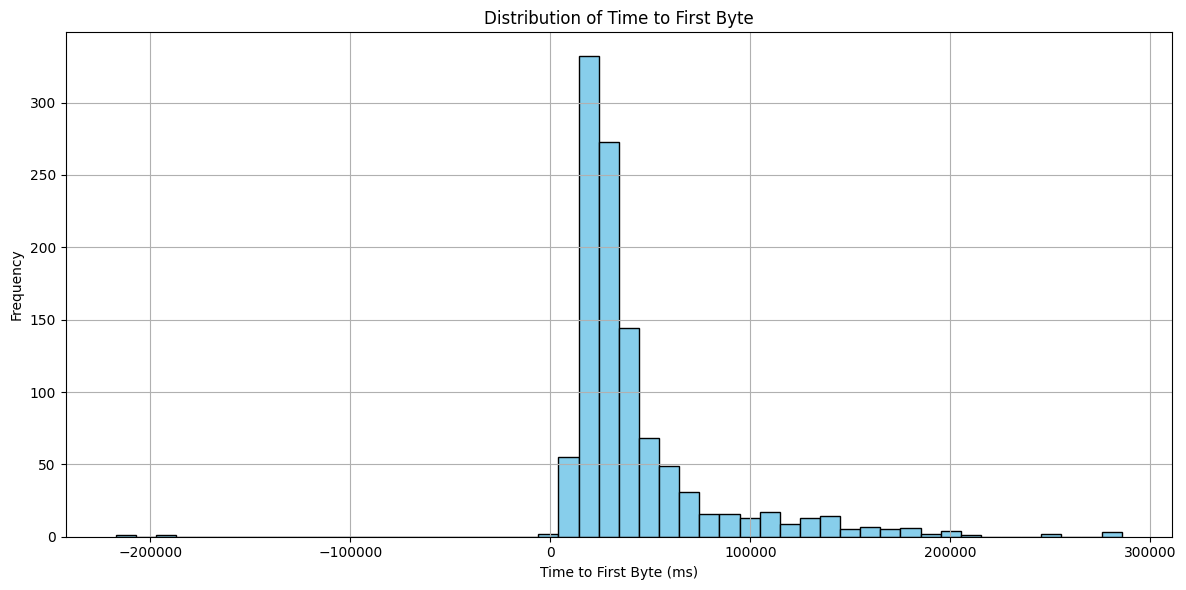

In [11]:
import matplotlib.pyplot as plt

# 히스토그램: time_to_first_byte 값 그대로 사용
plt.figure(figsize=(12, 6))
plt.hist(df_all['time_to_first_byte'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Time to First Byte')
plt.xlabel('Time to First Byte (ms)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
